<a href="https://colab.research.google.com/github/neekBruh/PrimerParcialIA2024/blob/main/Grommeck_1P_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primer Parcial IA 2024

- **Author**: Nicolas Grommeck 5376004

In [114]:
!pip install optuna

Se proporciona un conjunto de datos que contiene registros horarios de temperatura, y se espera que construyas un modelo de regresión para predecir tres valores clave de la temperatura del día siguiente: el percentil 95, el percentil 5, y la mediana.

# Librerias

In [115]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

1. Preparación de los datos:

    - Importe y cargue el conjunto de datos proporcionado.
    - Realice el preprocesamiento necesario, como la interpolación de valores faltantes, para obtener registros con frecuencia horaria.
    - Calcule los percentiles 95, 5, y la mediana de la temperatura para cada día. Agregar otras variables covariantes que puedan ayudar

# Importar Datos

In [116]:
SEED=1234
# Cargar el conjunto de datos
datos = pd.read_csv("Temp_Asu20092021.csv")

In [117]:
datos

,Unnamed: 0,Fecha,Temperatura,Humedad
0,0,2009-01-01 00:00:00,26.749483,69.609451
1,1,2009-01-01 03:00:00,25.956114,78.225166
2,2,2009-01-01 06:00:00,23.707357,93.551756
3,3,2009-01-01 09:00:00,23.726823,93.394817
4,4,2009-01-01 12:00:00,29.606379,72.155839
...,...,...,...,...
37979,37979,2021-12-31 09:00:00,21.719499,85.092387
37980,37980,2021-12-31 12:00:00,29.548918,53.780205
37981,37981,2021-12-31 15:00:00,40.026148,27.392646
37982,37982,2021-12-31 18:00:00,41.244712,19.955186


# Preprocesamiento

In [118]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

#interpolar para obtener valores hora a hora (esta cada 3 horas nomas el source)
datos = datos.resample('H').interpolate()

# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

datos




,Unnamed: 0,Temperatura,Humedad
Fecha,,,
2019-01-01 00:00:00,29216.000000,28.260936,66.311373
2019-01-01 01:00:00,29216.333333,27.857763,67.168400
2019-01-01 02:00:00,29216.666667,27.454591,68.025427
2019-01-01 03:00:00,29217.000000,27.051418,68.882454
2019-01-01 04:00:00,29217.333333,26.778952,70.141758
...,...,...,...
2021-12-31 17:00:00,37981.666667,40.838524,22.434340
2021-12-31 18:00:00,37982.000000,41.244712,19.955186
2021-12-31 19:00:00,37982.333333,40.044972,20.861568


La idea es ver que tipos de datos se tiene, para poder filtrar lo que sea innecesario

In [119]:
print(datos['Temperatura'].dtypes) #para ver los tipos de datos
print(datos['Humedad'].dtypes) #para ver los tipos de datos

print(datos.info())

float64
float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26302 entries, 2019-01-01 00:00:00 to 2021-12-31 21:00:00
Freq: H
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   26302 non-null  float64
 1   Temperatura  26302 non-null  float64
 2   Humedad      26302 non-null  float64
dtypes: float64(3)
memory usage: 821.9 KB
None


In [120]:
# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5),
                                                              ])

#percentiles_diarios
percentiles_diarios["Humedad"] = datos.resample('D')['Humedad'].agg([lambda x: np.percentile(x, 50)])

percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5', 'Humedad_media']

# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

print(percentiles_diarios)

# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

# Seleccionar características (por ejemplo,buscar variables adicionales)
X=percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)





            Percentil_95    Mediana  Percentil_5  Humedad_media  \
Fecha                                                             
2019-01-01     37.111315  30.471952    25.870503      58.454115   
2019-01-02     37.472491  31.976560    28.237027      53.247152   
2019-01-03     38.000942  32.251867    28.214334      49.091437   
2019-01-04     36.741240  32.588186    29.255833      45.644540   
2019-01-05     34.519138  29.500728    24.389532      67.807993   
...                  ...        ...          ...            ...   
2021-12-27     38.894335  29.901679    21.291239      19.332161   
2021-12-28     40.179396  29.333914    22.068336      23.140733   
2021-12-29     41.259412  30.513196    26.671474      21.827216   
2021-12-30     42.088614  30.551925    23.907302      30.382833   
2021-12-31     40.818214  28.971241    22.073834      51.491421   

            Percentil_95_siguiente_dia  Mediana_siguiente_dia  \
Fecha                                                          

In [121]:
percentiles_diarios

,Percentil_95,Mediana,Percentil_5,Humedad_media,Percentil_95_siguiente_dia,Mediana_siguiente_dia,Percentil_5_siguiente_dia
Fecha,,,,,,,
2019-01-01,37.111315,30.471952,25.870503,58.454115,37.472491,31.976560,28.237027
2019-01-02,37.472491,31.976560,28.237027,53.247152,38.000942,32.251867,28.214334
2019-01-03,38.000942,32.251867,28.214334,49.091437,36.741240,32.588186,29.255833
2019-01-04,36.741240,32.588186,29.255833,45.644540,34.519138,29.500728,24.389532
2019-01-05,34.519138,29.500728,24.389532,67.807993,36.064847,29.386275,27.622737
...,...,...,...,...,...,...,...
2021-12-26,39.436788,30.002068,22.728679,27.650931,38.894335,29.901679,21.291239
2021-12-27,38.894335,29.901679,21.291239,19.332161,40.179396,29.333914,22.068336
2021-12-28,40.179396,29.333914,22.068336,23.140733,41.259412,30.513196,26.671474


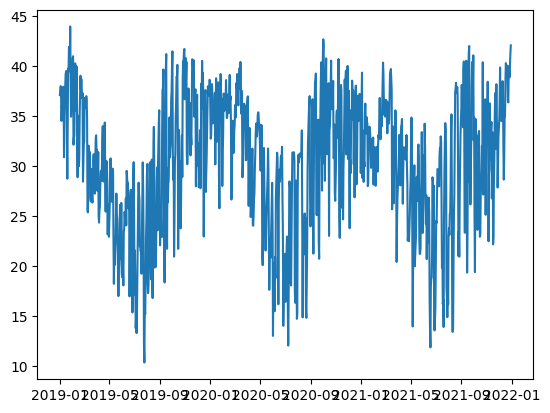

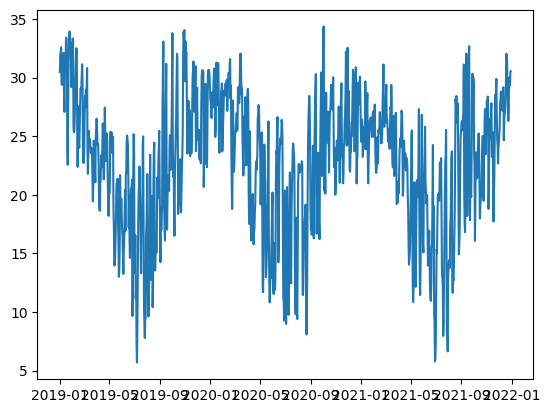

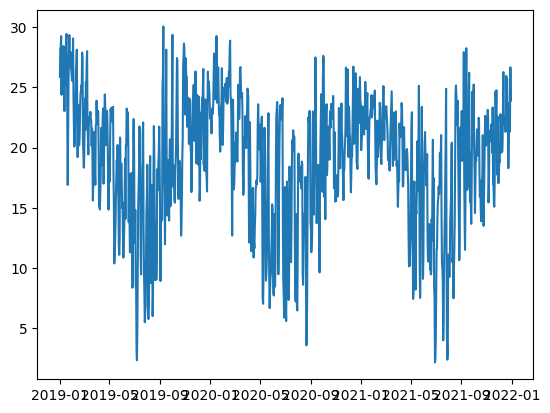

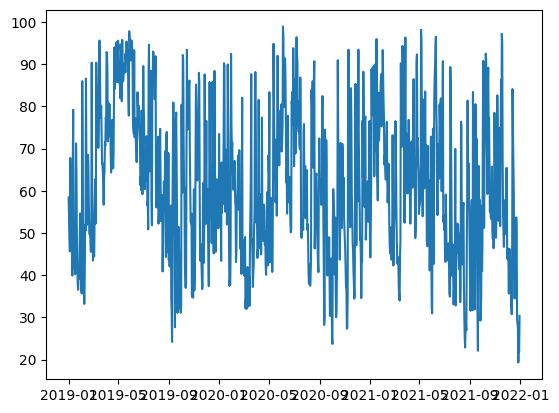

In [122]:
plt.figure(1)
plt.plot(percentiles_diarios['Percentil_95'])
plt.figure(2)
plt.plot(percentiles_diarios['Mediana'])
plt.figure(3)
plt.plot(percentiles_diarios['Percentil_5'])
plt.figure(4)
plt.plot(percentiles_diarios['Humedad_media'])

# Modelo

In [123]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

#mejor_num_capas =  3
training_epochs = 30

# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = trial.suggest_categorical('num_capas', [1, 10])
    tf.keras.utils.set_random_seed(SEED)

    #num_capas = 1
    # numero de neuronas por capa de Red neuronal
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64, 128])


    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))

    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=training_epochs, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=20)

# Obtener los mejores hiperparámetros

mejor_num_unidades = estudio.best_params['num_unidades']
mejor_num_capas = estudio.best_params['num_capas']

print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)


[I 2024-09-14 22:04:18,041] A new study created in memory with name: no-name-27c867e0-82c7-4806-b734-8cab4b4e635e
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2024-09-14 22:04:34,029] Trial 0 finished with value: 2.894944190979004 and parameters: {'num_capas': 10, 'num_unidades': 128}. Best is trial 0 with value: 2.894944190979004.
[I 2024-09-14 22:04:37,838] Trial 1 finished with value: 21.130168914794922 and parameters: {'num_capas': 1, 'num_unidades': 32}. Best is trial 0 with value: 2.894944190979004.
[I 2024-09-14 22:04:45,191] Trial 2 finished with value: 2.894944190979004 and parameters: {'num_capas': 10, 'num_unidades': 128}. Best is trial 0 with value: 2.894944190979004.
[I 2024-09-14 22:04:52,071] Trial 3 finished with value: 4.052648544311523 and parameters: {

Mejores Hiperparámetros:
Número de Capas: 10
Número de Unidades: 128


In [124]:
optuna.visualization.plot_optimization_history(estudio)

In [125]:
optuna.visualization.plot_param_importances(estudio)

# Entrenar

In [126]:


# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))

for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))

modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['mae'])

# Entrenar el modelo final
history = modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=training_epochs, batch_size=256, verbose=1, shuffle=False)

# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - loss: 635.7220 - mae: 24.0893 - val_loss: 587.8029 - val_mae: 22.8526
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 622.9287 - mae: 23.8164 - val_loss: 546.9874 - val_mae: 21.8687
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 561.6830 - mae: 22.4526 - val_loss: 391.3040 - val_mae: 17.8651
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 344.1574 - mae: 16.9575 - val_loss: 302.2677 - val_mae: 12.5150
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 224.0447 - mae: 11.3322 - val_loss: 163.6932 - val_mae: 9.8632
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 129.6974 - mae: 9.2234 - val_loss: 116.9364 - val_mae: 9.0921
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98.4159 - mae: 8.2857 - val_loss: 91.7704 - val_mae: 7.6796
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 95.4970 - mae: 7.6903 - val_loss: 76.9022 - val_mae: 6.9915
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

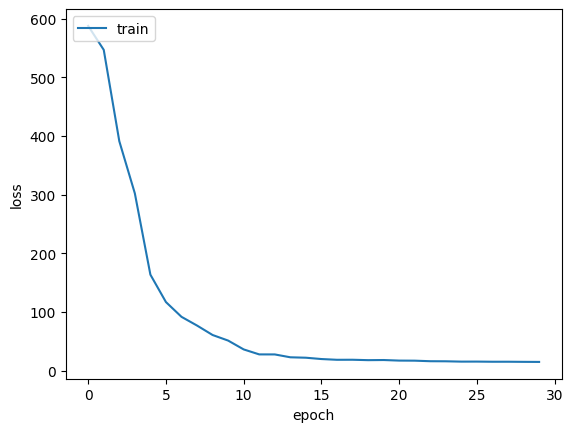

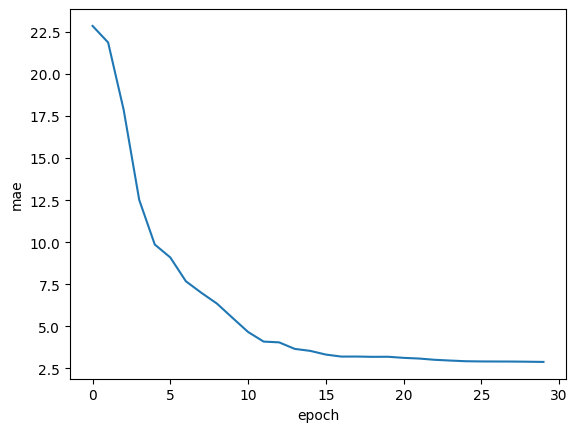

In [127]:


plt.figure()
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure()
plt.plot(history.history['val_mae'])
plt.ylabel('mae')
plt.xlabel('epoch')

plt.show()



# Test

In [128]:
X_validacion[:,0]

array([-0.51920185, -0.28406303,  0.4678503 , -0.48535272, -1.07231856,
       -0.8010209 , -0.40481987,  0.11689164, -0.12784139,  0.59650536,
        0.24815018, -0.60780411, -0.93729539, -0.49848225, -1.47071786,
       -0.93872261, -1.2314037 , -1.08947729, -0.87887544, -0.53136525,
       -0.77008935, -2.04252043, -2.55682943, -2.81839766, -1.89134039,
       -1.77299779, -1.74971151, -1.41519966, -0.2219914 , -0.27752145,
       -1.49109998, -0.34557536, -2.40806992, -2.55957666, -2.37313205,
       -2.22935443, -1.48436224, -0.89076742, -0.91933611, -0.48809439,
       -0.09745278, -0.10371529, -0.12100262, -0.18817828, -0.35995001,
        0.08601294,  0.22380073,  0.21421447,  0.40319453,  0.32105238,
       -0.66791228, -1.59950393, -1.23476153, -2.15900328, -2.08399525,
       -2.50751446, -0.84814831, -0.13619338,  0.30283895,  0.60575498,
        0.51483679,  0.11962941, -1.8976932 , -2.05646765, -2.35765945,
       -1.95500546, -2.16315021, -1.11421752, -1.00066793, -1.10

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


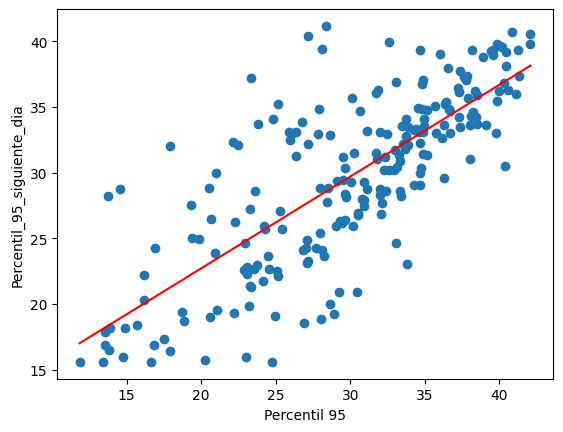

R^2: 0.5654605678631902


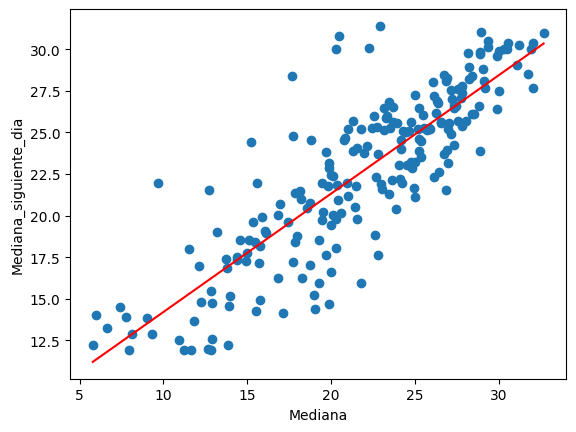

R^2: 0.706391719966514


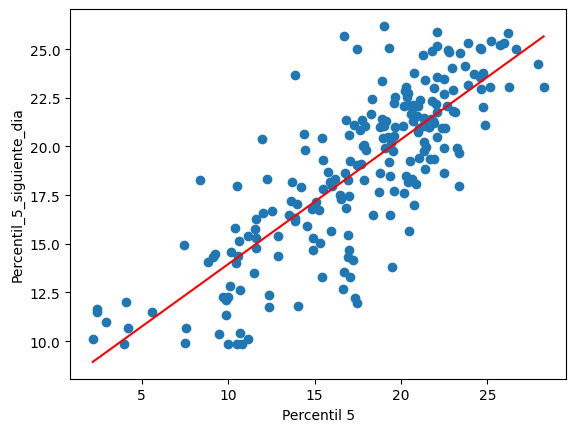

R^2: 0.6080840921284412


In [133]:
Y_prediction = modelo_final.predict(X_validacion)


#['Percentil_95','Mediana','Percentil_5']

Y = y_validacion[:,0]
Y_pred = Y_prediction[:,0]

slope, intercept = np.polyfit(Y, Y_pred, 1)  # 1 means a linear fit
line_x = np.linspace(Y.min(), Y.max(), 100)
line_y = slope * line_x + intercept


plt.figure()
plt.scatter(Y, Y_pred)
plt.plot(line_x, line_y, color='red', label='Fitted Line')
plt.xlabel('Percentil 95')
plt.ylabel('Percentil_95_siguiente_dia')
plt.show()

r2 = r2_score(Y, Y_pred)
print(f"R^2: {r2}")

Y = y_validacion[:,1]
Y_pred = Y_prediction[:,1]

slope, intercept = np.polyfit(Y, Y_pred, 1)  # 1 means a linear fit
line_x = np.linspace(Y.min(), Y.max(), 100)
line_y = slope * line_x + intercept


plt.figure()
plt.scatter(Y, Y_pred)
plt.plot(line_x, line_y, color='red', label='Fitted Line')
plt.xlabel('Mediana')
plt.ylabel('Mediana_siguiente_dia')
plt.show()

r2 = r2_score(Y, Y_pred)
print(f"R^2: {r2}")

Y = y_validacion[:,2]
Y_pred = Y_prediction[:,2]

slope, intercept = np.polyfit(Y, Y_pred, 1)  # 1 means a linear fit
line_x = np.linspace(Y.min(), Y.max(), 100)
line_y = slope * line_x + intercept


plt.figure()
plt.scatter(Y, Y_pred)
plt.plot(line_x, line_y, color='red', label='Fitted Line')
plt.xlabel('Percentil 5')
plt.ylabel('Percentil_5_siguiente_dia')
plt.show()

r2 = r2_score(Y, Y_pred)
print(f"R^2: {r2}")
